In [1]:
import pandas as pd
import numpy as np
import os
from bokeh.io import output_notebook, show
output_notebook()
import bokeh as bh
from sklearn.preprocessing import LabelEncoder
from glob import glob
import re
from math import ceil
import xgboost as xgb
from sklearn.model_selection import GroupKFold,KFold
import random
import operator
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing
pd.options.display.max_columns = 1000

Loading BokehJS ...

In [2]:
os.chdir('C:/Users/pavan.velaga/Downloads')
train = pd.read_csv( "CAX_MortgageModeling_Train.csv")
test = pd.read_csv("CAX_MortgageModeling_Test.csv")

#### Fearture Engineering

In [57]:
def feature_creation(df):
    df['anl_housing_exp'] = df['INCOME'] * df['GDS']
    df['appriesed_property_value'] = df['MORTGAGE AMOUNT']/df['LTV']
    
    df['property_apprl'] = df['appriesed_property_value']/df['PROPERTY VALUE']
    df['n_years'] = df['AMORTIZATION']/12
    df['anl_income'] = df['INCOME']/df['n_years']
    df['other_expenses'] = (df['anl_income']*df['TDS']) - df['anl_housing_exp']
    df['othr_exp_ratio'] = df['other_expenses']/df['anl_income']
    df['rate_property_apprl_yr'] = df['property_apprl']/df['n_years']
    df['rate_property_apprl_trm'] = df['property_apprl']/df['TERM']
    df['rate_property_apprl_month'] = df['property_apprl']/df['AMORTIZATION']
    df['dipo_income'] = df['anl_income'] - df['other_expenses'] - df['anl_housing_exp']
    df['dispo_inc_rto'] = df['dipo_income']/df['anl_income']
    
    return(df)

In [58]:
train = feature_creation(train)
test = feature_creation(test)

In [59]:
train['target'] = train['RESULT'].map({"FUNDED":0,"NOT FUNDED":1})

In [85]:
features = ['PROPERTY VALUE', 'MORTGAGE PAYMENT',
       'GDS', 'LTV', 'TDS', 'AMORTIZATION', 'MORTGAGE AMOUNT', 'RATE',
       'MORTGAGE PURPOSE', 'PAYMENT FREQUENCY', 'PROPERTY TYPE', 'TERM', 'FSA',
       'AGE RANGE', 'GENDER', 'INCOME', 'INCOME TYPE', 'NAICS CODE','anl_housing_exp','appriesed_property_value'
            ,'property_apprl','other_expenses','rate_property_apprl_yr','dipo_income']
target = ['target']

In [86]:
for f in features:
    if train[f].dtype=='object':
        print(f+"-"+str(train[f].dtype))
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(train[f].values) + list(test[f].values))
        train[f] = lbl.transform(list(train[f].values))
        test[f] = lbl.transform(list(test[f].values))

In [87]:
class MetricsMeter():    
    def __init__(self, y_true, y_pred, threshold):
        self.y_true = y_true        
        self.y_pred = y_pred        
        self.thresh = threshold            
    
    def fit(self):        
        metrics = {}        
        metrics['auc'] = roc_auc_score(self.y_true, self.y_pred)                
        self.y_pred = [1 if x > self.thresh else 0 for x in self.y_pred]        
        metrics['f1'] = f1_score(self.y_true, self.y_pred,average = 'macro')        
        tn, fp, fn, tp = confusion_matrix(self.y_true, self.y_pred).ravel()                
        metrics['sensitivity/recall'] = tp / (tp+fn)
        metrics['precision'] = tp / (tp+fp)
        metrics["accuracy"] = (tp + tn) / (tp + fp + fn + tn)
        metrics['specificity'] = tn / (tn+fp)
        return metrics

### Validation Framework

In [88]:
train = train.reset_index(drop =True)
x_train = train[features]
y_train = train[target]

In [89]:
def RunXGB(x_build,x_val,y_build,y_val,dtest,seed):
    dbuild = xgb.DMatrix(x_build,y_build)
    dval = xgb.DMatrix(x_val,y_val)
    watchlist = [(dbuild, 'train'), (dval, 'val')]
    params = {'objective': 'binary:logistic',
              'booster': 'gbtree',
              'eval_metric': 'auc',
              'nthread': 4,
              'max_depth': 5,
              'subsample': 0.8,
              'min_child_weight': 1,
              "colsample_bytree": 0.9,
              'eta': 0.08,
              'verbose_eval': True,
              'silent':1,
              'seed': seed
              }
    clf_xgb = xgb.train(params, dbuild, num_boost_round=2000, verbose_eval=200, early_stopping_rounds=30, evals=watchlist)
    pred_val = clf_xgb.predict(dval, ntree_limit=clf_xgb.best_iteration)
    pred_t = clf_xgb.predict(dtest, ntree_limit=clf_xgb.best_iteration)
    return(clf_xgb,pred_val,pred_t)
    
    

    

In [90]:
n_splits = 5
cv_scores = []
pred_test_f = 0
pred_train = np.zeros(train.shape[0])
dtest = xgb.DMatrix(test[features])
kf = KFold(n_splits=n_splits, shuffle=True, random_state=99)
for build_index, val_index in kf.split(x_train, y_train):
    x_build = x_train.iloc[build_index, :]
    y_build = y_train.iloc[build_index, :]
    x_val = x_train.iloc[val_index]
    y_val = y_train.iloc[val_index]
    pred_val = 0
    pred_test = 0
    n_models = 0.
    
    model,pred_v,pred_t = RunXGB(x_build,x_val,y_build,y_val,dtest,seed = 10999973) 
    pred_val += pred_v
    pred_test += pred_t
    n_models += 1
    
    model,pred_v,pred_t = RunXGB(x_build,x_val,y_build,y_val,dtest,seed = 99) 
    pred_val += pred_v
    pred_test += pred_t
    n_models += 1

    
    model,pred_v,pred_t = RunXGB(x_build,x_val,y_build,y_val,dtest,seed = 90351) 
    pred_val += pred_v
    pred_test += pred_t
    n_models += 1
    
    pred_val /= n_models
    pred_test /= n_models

    
    pred_train[val_index] = pred_val
    print(min(pred_train)),print(max(pred_train))
    pred_test_f += pred_test / n_splits
    print(min(pred_test_f)),print(max(pred_test_f))
    #xgb_preds_lst.append(clf_xgb.predict(dtest))  
    #models.append(clf_xgb)

    
    


[0]	train-auc:0.669156	val-auc:0.672255
Multiple eval metrics have been passed: 'val-auc' will be used for early stopping.

Will train until val-auc hasn't improved in 30 rounds.
[200]	train-auc:0.828521	val-auc:0.746688
Stopping. Best iteration:
[269]	train-auc:0.853622	val-auc:0.751791

[0]	train-auc:0.675942	val-auc:0.67565
Multiple eval metrics have been passed: 'val-auc' will be used for early stopping.

Will train until val-auc hasn't improved in 30 rounds.
[200]	train-auc:0.825219	val-auc:0.745234
[400]	train-auc:0.877291	val-auc:0.750378
Stopping. Best iteration:
[392]	train-auc:0.875691	val-auc:0.750767

[0]	train-auc:0.675317	val-auc:0.66878
Multiple eval metrics have been passed: 'val-auc' will be used for early stopping.

Will train until val-auc hasn't improved in 30 rounds.
[200]	train-auc:0.827767	val-auc:0.746435
Stopping. Best iteration:
[339]	train-auc:0.871812	val-auc:0.750809

0.0
0.9957492351531982
5.1309624e-05
0.19921908
[0]	train-auc:0.670971	val-auc:0.665735
Mu

In [77]:
min(pred_train),max(pred_train)

(0.000334180862409994, 0.9974358081817627)

In [78]:
n_models

3.0

In [79]:
min(pred_test_f),max(pred_test_f)

(0.00060143124, 0.993972)

In [80]:
pred_train.shape

(45642,)

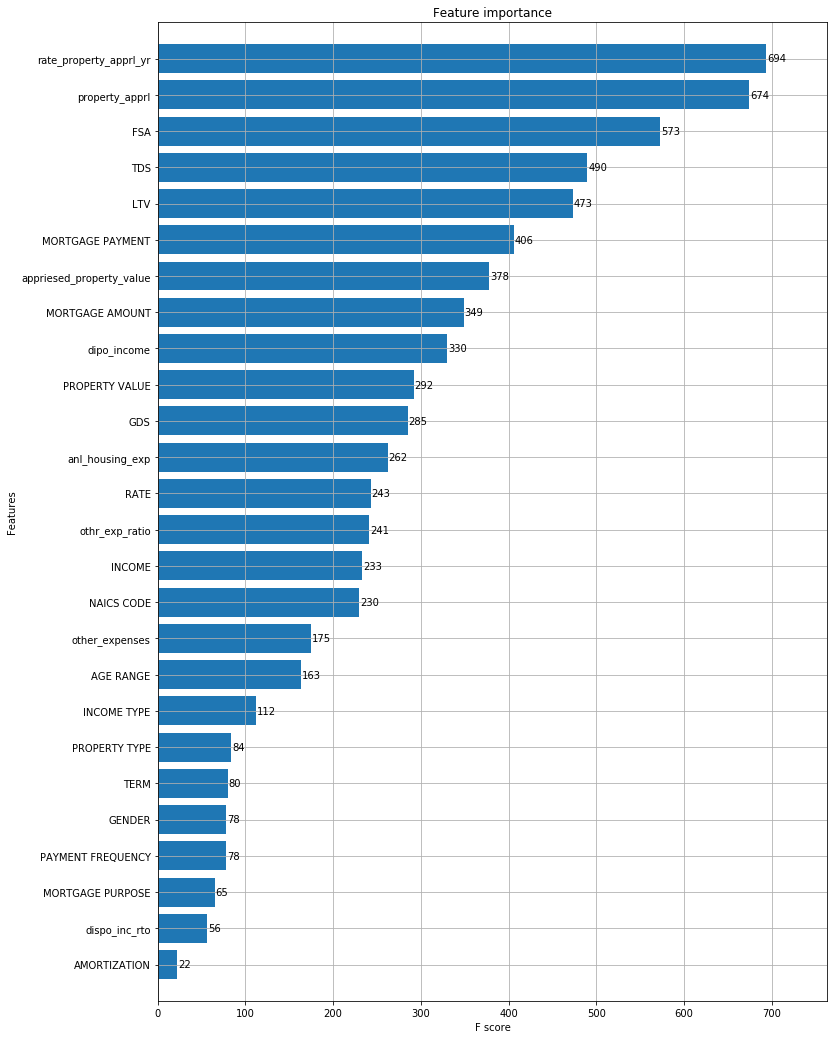

In [81]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(model,max_num_features=50, height=0.8, ax=ax)
plt.show()


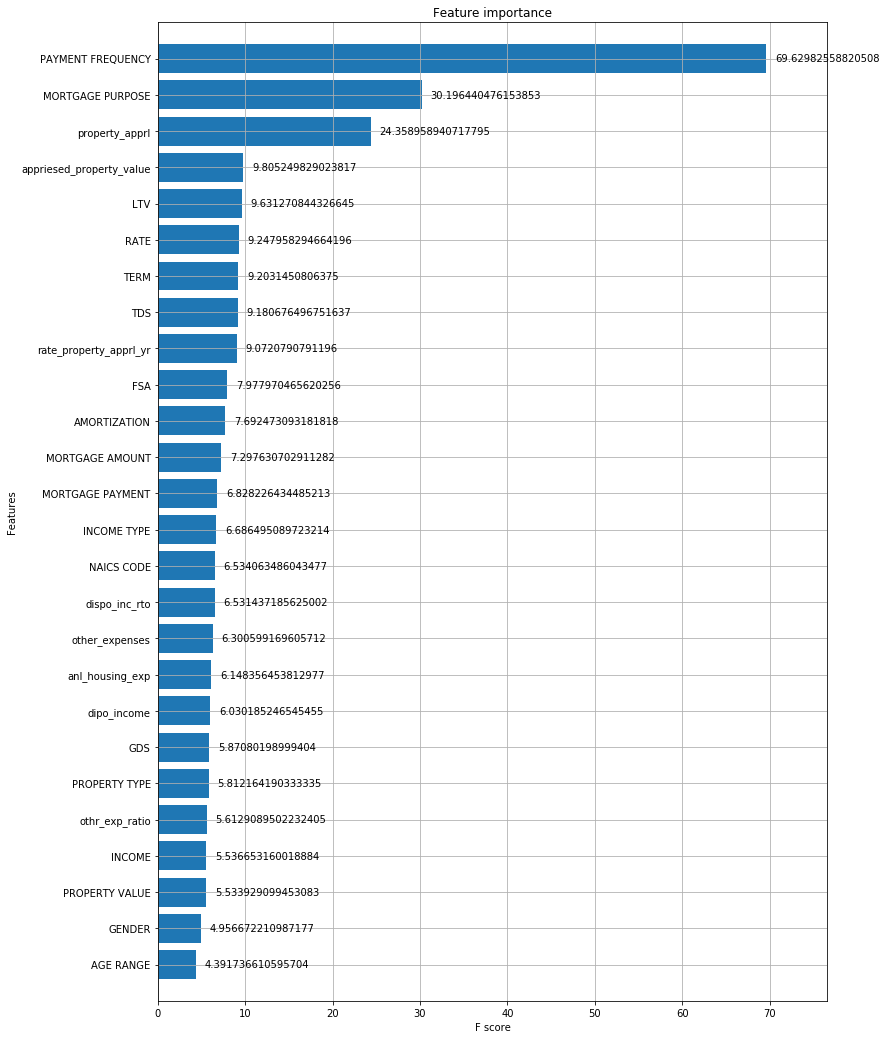

In [82]:

fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(model,importance_type= "gain", max_num_features=50, height=0.8, ax=ax)
plt.show()


In [83]:
m = [] 
for i in np.linspace(0.01, 0.99, num=90):    
    dr_metrics = MetricsMeter(y_train, pred_train, i)
    scores = dr_metrics.fit()    
    scores['thresh'] = i    
    m.append(scores) 
m_build = pd.DataFrame(m)

a = m_build.sort_values('f1', ascending=False)

In [84]:
a.head(10) #0.665855

,accuracy,auc,f1,precision,sensitivity/recall,specificity,thresh
27,0.783949,0.754555,0.664267,0.486206,0.443393,0.874885,0.307303
25,0.771219,0.754555,0.663718,0.459724,0.488304,0.846765,0.285281
26,0.777398,0.754555,0.663474,0.471427,0.463978,0.861089,0.296292
28,0.789142,0.754555,0.663232,0.499692,0.421561,0.887294,0.318315
24,0.763113,0.754555,0.662251,0.446169,0.513983,0.829637,0.274270
29,0.793589,0.754555,0.662052,0.513116,0.402641,0.897982,0.329326
23,0.753779,0.754555,0.659160,0.432401,0.538310,0.811315,0.263258
30,0.796854,0.754555,0.658071,0.524982,0.379041,0.908420,0.340337
22,0.743876,0.754555,0.655431,0.419722,0.562844,0.792216,0.252247
31,0.799790,0.754555,0.654563,0.537409,0.359185,0.917442,0.351348


In [29]:
test['preds'] = pred_test_f
test['Result_Predicted'] = np.where(test['preds']>0.296292,'NOT FUNDED','FUNDED')
final_sub = test[['Unique_ID','Result_Predicted']]

In [30]:
final_sub['Result_Predicted'].value_counts()

FUNDED        12158
NOT FUNDED     3056
Name: Result_Predicted, dtype: int64

In [32]:
final_sub.to_csv('new_ft_sub19v.csv',index=False)